In [17]:
import os


from optuna.logging import set_verbosity, WARNING
os.system('cls' if os.name == 'nt' else 'clear')
import json
import joblib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import List, Tuple
from torch.amp import autocast, GradScaler

from tqdm.auto import tqdm
from optuna.logging import set_verbosity, CRITICAL
import sys
from sklearn.metrics import f1_score, roc_auc_score
from tsaug import TimeWarp, Drift, Reverse, Quantize, AddNoise

In [18]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
optuna.seed = seed

os.environ["OMP_NUM_THREADS"] = "1"    # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [19]:
# --- Step 1: Load the Data ---
X = pd.read_csv("x_df.csv", parse_dates=['admittime', 'dischtime'])
y = pd.read_csv("y_df.csv")

In [20]:
def preprocess_data(
    x_df: pd.DataFrame,
    y_df: pd.DataFrame,
    sequence_length: int,
    exclude_columns: List[str]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepares padded sequential data for LSTM input from admission records.

    Args:
        x_df (pd.DataFrame): Feature dataframe containing 'subject_id' and 'admittime'.
        y_df (pd.DataFrame): Label dataframe (should align with x_df).
        sequence_length (int): Max number of admissions in a sequence.
        exclude_columns (List[str]): Columns to exclude from features.

    Returns:
        Tuple:
            sequences (np.ndarray): Array of shape (samples, sequence_length, num_features).
            labels (np.ndarray): Labels for each sequence.
            lengths (np.ndarray): Actual length of each sequence before padding.
            groups (np.ndarray): Patient ID (subject_id) for each sequence.
    """
    y_df = y_df.astype(int)
    x_df = x_df.copy()
    y_df["label"] = x_df["label"]   # Ensure label is merged

    sequences = []
    labels = []
    lengths = []
    groups = []

    for subject_id, group in x_df.groupby("subject_id"):
        group = group.sort_values("admittime")

        features = group.drop(columns=exclude_columns).values
        targets = group["label"].values
        num_admissions = len(group)

        if num_admissions >= 1:
            for i in range(1, num_admissions):
                start_idx = max(0, i - sequence_length)
                seq = features[start_idx:i]

                true_len = len(seq)

                # Pad sequence if needed
                if true_len < sequence_length:
                    padding = np.zeros((sequence_length - true_len, seq.shape[1]))
                    seq = np.vstack((padding, seq))

                sequences.append(seq)
                labels.append(targets[i])
                lengths.append(true_len)
                groups.append(subject_id)

    return (
        np.array(sequences),
        np.array(labels),
        np.array(lengths),
        np.array(groups)
    )

#(X, y, lengths,groups) =  preprocess_data(x_df, y_df,sequence_length,exclude_columns)

In [21]:
def prepare_data(x__df: pd.DataFrame,y__df: pd.DataFrame,sequence_length=9 ):
    x_df = x__df.copy()
    y_df = y__df.copy()

    y_df = y_df.astype(int)
    bool_cols = x_df.select_dtypes(include='bool').columns
    x_df[bool_cols] = x_df[bool_cols].astype(int)

    # Merge labels with features
    x_df['label'] = y_df['label']

    # --- Step 2: Sort by patient and admission time ---
    x_df=x_df.sort_values(by=['subject_id', 'admittime'])

    # --- Step 3: Set parameters ---

    exclude_columns = ['subject_id', 'admittime', 'dischtime', 'label']

    # --- Step 4: Create sequences ---
    sequences = []
    labels = []

    exclude_columns = ['subject_id', 'admittime', 'dischtime', 'label']

    (X, y, lengths,groups)=preprocess_data(x_df, y_df, sequence_length, exclude_columns)
    return X, y, lengths, groups

In [22]:
class ReadmissionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y,lengths):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (N, T, F)
        self.y = torch.tensor(y, dtype=torch.long)     # long for classification
        self.lengths = torch.tensor(lengths, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_seq = self.X[idx]
        y_val = self.y[idx]
        length = self.lengths[idx]
        return x_seq, length, x_seq, y_val  # return twice for LSTM and CNN input

count    4322.000000
mean        1.105507
std         0.408736
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: count, dtype: float64


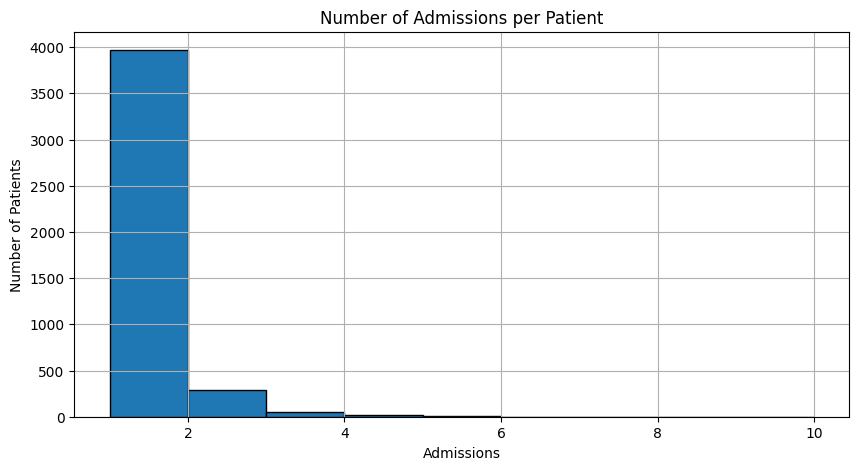

In [23]:
admission_counts = X['subject_id'].value_counts().sort_index()
admission_stats = admission_counts.describe()
print(admission_stats)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(admission_counts, bins=range(1, admission_counts.max() + 2), edgecolor='black')
plt.title("Number of Admissions per Patient")
plt.xlabel("Admissions")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()



In [24]:
X_train_all_, X_test_, y_train_all_, y_test_ = train_test_split(X,y,
    test_size=0.2,
    random_state=42,
    stratify=y  # optional: preserves label ratio
)

In [25]:
sequence_length = 9
(X_test, y_test, lengths_test, group_test) = prepare_data(X_test_, y_test_, sequence_length)
print(X_test.shape)
test_data = ReadmissionDataset(X_test, y_test, lengths_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
num_features = X_test.shape[2]

(21, 9, 41)


In [26]:
(X_train_all,y_train_all,lengths_train,group_train) = prepare_data(X_train_all_, y_train_all_,sequence_length)

In [27]:
class LSTMStack(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMStack, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

    def forward(self, x,lengths):
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output, (hn, cn) = self.lstm(packed)
        return hn[-1]  # (batch_size, hidden_size)  <-- 2D

class CNNExtractor(nn.Module):
    def __init__(self, input_size, cnn_channels, kernel_size, dropout):
        super(CNNExtractor, self).__init__()
        self.input_size = input_size
        self.cnn_channels = cnn_channels
        padding = kernel_size // 2
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, cnn_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),

            nn.Conv1d(cnn_channels, cnn_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),

            nn.Dropout(dropout)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x expected as (B, S, F); Conv1d wants (B, F, S)
        x = x.permute(0, 2, 1)              # (B, F, S)
        x = self.cnn(x)                     # (B, C, S)
        # Collapse the time dimension so we return 2D features
        x = self.global_pool(x)
        x = x.squeeze(-1)

        return x  # (batch_size, cnn_channels)  <-- 2D

class DiagnosisModel(nn.Module):
    def __init__(self, input_size, hidden_size, cnn_channels, kernel_size, num_layers, dropout):
        super(DiagnosisModel, self).__init__()
        self.lstm = LSTMStack(input_size, hidden_size, num_layers)
        self.cnn = CNNExtractor(input_size, cnn_channels, kernel_size, dropout)

        in_features = hidden_size + cnn_channels  # match what we actually concatenate
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # 2 classe
        )

    def forward(self, lstm_input,lengths, cnn_input):
        lstm_features = self.lstm(lstm_input,lengths)   # (B, hidden_size)
        cnn_features = self.cnn(cnn_input)      # (B, cnn_channels)

        # Both branches are 2D now, so concatenation works
        combined = torch.cat([lstm_features, cnn_features], dim=1)  # (B, hidden_size + cnn_channels)
        return self.mlp(combined)  # (batch_size, 2)

In [28]:
def train(model, dataloader, optimizer, criterion, device,epochs):
    castauto=False
    model.train()
    histroy = []
    for i in range(epochs):
        epoch_loss = 0.0
        for X_batch,length_batch,lstm_batch, y_batch in tqdm(dataloader, desc=f"Epoch {i+1}/{epochs}", leave=False,ncols=80):
            lstm_batch = lstm_batch.to(device)

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            if length_batch.dim() > 1:
                    length_batch = length_batch.squeeze(-1)
            length_batch = length_batch.to(torch.int64)
            preds = model(lstm_batch,length_batch,X_batch)
            loss = criterion(preds, y_batch.long())
            loss.backward()
            optimizer.step()


            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        histroy.append(avg_loss)
        print(f"Epoch {epochs + 1}/{epochs} - Loss: {avg_loss:.4f}")
    return model,histroy

In [29]:
def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_pos_scores = []
    with torch.no_grad():
        for X_batch,length_batch,lstm_batch, y_batch in  dataloader:
            lstm_batch = lstm_batch.to(device)
            X_batch = X_batch.to(device)
            if length_batch.dim() > 1:
                length_batch = length_batch.squeeze(-1)
            length_batch = length_batch.to(torch.int64)
            logits = model(lstm_batch,length_batch, X_batch)              # (B, 2), raw logits
            probs_pos = torch.softmax(logits, dim=1)[:, 1]          # (B,), P(class=1
            all_pos_scores.append(probs_pos.detach().cpu())
            all_labels.append(y_batch.detach().cpu())


        if len(all_labels) == 0 or len(all_pos_scores) == 0:
            print("⚠️ Validation produced no batches. Returning score = 0.0")
            return 0.0

    y_true = torch.cat(all_labels,dim=0).numpy()                      # shape (N,)
    y_score = torch.cat(all_pos_scores,dim=0).numpy()

    return model,y_true,y_score

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        
        """
        alpha: Optional weight for each class (list, Tensor) or scalar for binary
        gamma: Focusing parameter
        reduction: 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                self.alpha = torch.tensor(alpha, dtype=torch.float32)
            elif isinstance(alpha, torch.Tensor):
                self.alpha = alpha
            else:
                self.alpha = torch.tensor([alpha, 1 - alpha], dtype=torch.float32)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        """
        inputs: [B, C] raw logits
        targets: [B] class indices
        """
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        targets = targets.view(-1, 1)

        log_pt = log_probs.gather(1, targets)
        pt = probs.gather(1, targets)

        if self.alpha is not None:
            at = self.alpha.to(inputs.device).gather(0, targets.squeeze())
            log_pt = log_pt * at.view(-1, 1)

        loss = -((1 - pt) ** self.gamma) * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [31]:
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import contextlib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import gc

# ------------------------------
# Optuna Objective Function
# ------------------------------

X_train_all,y_train_all,lengths_train,group_train

def objective(trial):
    import torch
    import torch.nn as nn


    torch.backends.cudnn.benchmark = True
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)



    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    kernel_size = trial.suggest_int("kernel_size", 1, 3)
    cnn_channels = trial.suggest_int("cnn_channels", 16, 64)

    input_size= num_features
    model = DiagnosisModel(input_size=input_size, hidden_size=hidden_dim,cnn_channels=cnn_channels,kernel_size=kernel_size ,num_layers=num_layers,dropout=dropout)

    #print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    #criterion = nn.CrossEntropyLoss()

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    aucs = []

    for fold,(train_index, val_index) in enumerate(skf.split(X_train_all, y_train_all,groups=group_train)):

        X_train, X_val = X_train_all[train_index], X_train_all[val_index]
        y_train, y_val = y_train_all[train_index], y_train_all[val_index]
        len_train = lengths_train[train_index]
        len_val = lengths_train[val_index]

        if optimizer_name == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = (torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9))

        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train_ = X_train[indices]
        y_train_ = y_train[indices]
        len_train_ = len_train[indices]

        # 📊 Class distribution AFTER oversampling
        new_counts = Counter(y_train)

        print("  Sample:")
        for cls, count in new_counts.items():
            print(f"  Class {cls}: {count} samples")

                # --------------------------
        # Compute and apply class weights
        # --------------------------
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_), y=y_train_)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = FocalLoss(alpha=class_weights, gamma=2.0).to(device)

        train_data = ReadmissionDataset(X_train, y_train,len_train)
        val_data = ReadmissionDataset(X_val, y_val,len_val)

        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

        (model,loss) = train(model, train_loader, optimizer, criterion, device,epochs=5)

        # Evaluate
        (model,y_true,y_score)= evaluate(model, val_loader, device)


        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true, y_score)                        # binary ROC AUC
        aucs.append(auc)

        # --------------------------
        # Final AUC Score
        # --------------------------
        if len(aucs) == 0:
            return 0.0  # all folds failed

        # Cleanup
        #del train_loader, val_loader
        #torch.cuda.empty_cache()
        #gc.collect()

    mean_auc = float(np.mean(aucs))
    return mean_auc


In [ ]:
# Ensure output folder exists
os.makedirs("model", exist_ok=True)

# Silence Optuna's logs, but keep tqdm bar
set_verbosity(CRITICAL)
optuna.logging.disable_default_handler()

print("🔍 Starting Optuna optimization with progress bar...\n")

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True
)

study.optimize(
    objective,
    n_trials=100,
    n_jobs=8,
    show_progress_bar=True  # 👈 tqdm-style global progress bar
)

print("\n✅ Optimization complete!")

# Save and report best result
joblib.dump(study, "model/optuna_studyv4.pkl")
with open("model/best_paramsv4.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=2)

print("\n🏆 Best trial:")
print(study.best_trial)

from IPython.display import display, HTML
display(HTML("<style>.output_scroll {height: 100px; overflow-y: scroll;}</style>"))

🔍 Starting Optuna optimization with progress bar...



  0%|          | 0/100 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1805


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1797


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1806


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1794


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636
Epoch 6/5 - Loss: 0.1628


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3598


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1987


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1634


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1683
Epoch 6/5 - Loss: 0.2292


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1637


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1855


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1630
Epoch 6/5 - Loss: 0.1617


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596
Epoch 6/5 - Loss: 0.1918


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1650


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598
Epoch 6/5 - Loss: 0.1598
Epoch 6/5 - Loss: 0.1819
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1741


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1871


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1745


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1743


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1536


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1726


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1833


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1738


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1727
Epoch 6/5 - Loss: 0.1888


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1738
Epoch 6/5 - Loss: 0.1724


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1722


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1726


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.1855

  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1706


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2194


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1731
Epoch 6/5 - Loss: 0.1411


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1640


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772
Epoch 6/5 - Loss: 0.1542
Epoch 6/5 - Loss: 0.1786


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1762


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2086


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1668


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1723


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1579


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1643


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1607


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1641


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1641


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1693


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1715


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2095


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636
Epoch 6/5 - Loss: 0.1803


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1627


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1679


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1635


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1668


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1737


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1622
Epoch 6/5 - Loss: 0.1668


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1659
Epoch 6/5 - Loss: 0.1386


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.2027

  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1737
Epoch 6/5 - Loss: 0.1689


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1729


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739
Epoch 6/5 - Loss: 0.1739


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2092
Epoch 6/5 - Loss: 0.1738


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2197


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1631


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2067


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2183


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1609


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1880


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2177


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1614


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1632
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1272
Epoch 6/5 - Loss: 0.1436


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1811


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1624


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1495


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1409


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1630


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0969


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1605
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1541


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2093


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0722
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1813


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1417


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1746


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1836


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2036


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1333


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0918


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1809


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1667


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1819
Epoch 6/5 - Loss: 0.1531
Epoch 6/5 - Loss: 0.0784


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1722


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1261
Epoch 6/5 - Loss: 0.1568


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1707
Epoch 6/5 - Loss: 0.1229
Epoch 6/5 - Loss: 0.1661


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1485


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1997
Epoch 6/5 - Loss: 0.1360


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1594


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1762


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1758


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1367
Epoch 6/5 - Loss: 0.1578


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1082
Epoch 6/5 - Loss: 0.1765


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1765


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1542


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1766
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1539


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1522
Epoch 6/5 - Loss: 0.1395
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560
Epoch 6/5 - Loss: 0.1618


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1487


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1144


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1603


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2056


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1081


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1818


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1630


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1499


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1743
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1432


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1680


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1274


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1444


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1797
Epoch 6/5 - Loss: 0.1698


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1058


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2630


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2127


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2007


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.0796


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1888
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1693
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1775
Epoch 6/5 - Loss: 0.1693
Epoch 6/5 - Loss: 0.1510


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1730


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1082


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1719


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1711


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1716


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0911


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1702


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1106


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1725


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1181


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1760


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1692


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.5036


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1758


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0975


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1761


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1694
Epoch 6/5 - Loss: 0.0833


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1755


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2116


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0610


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.0844


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3812
Epoch 6/5 - Loss: 0.1764
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0497
Epoch 6/5 - Loss: 0.1674


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1845


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0694


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2129


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2101


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596
Epoch 6/5 - Loss: 0.1784


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0806


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1732


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1664


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0686


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1674
Epoch 6/5 - Loss: 0.0538


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1538
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0389


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1287


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2118


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0333


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0450
Epoch 6/5 - Loss: 0.1701
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0204
Epoch 6/5 - Loss: 0.1597


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1545
Epoch 6/5 - Loss: 0.1615


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0961


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3080


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1036


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1458


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1682


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2178


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1649


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1795


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1645


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1396


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1484


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1769


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1626


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1510
Epoch 6/5 - Loss: 0.0856
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0838


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1606


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1728


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1586


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1783


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0539


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0723


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2104


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1833


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1666


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1725
Epoch 6/5 - Loss: 0.1556


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1818


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1521


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1526


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1661


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1522
Epoch 6/5 - Loss: 0.1456


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1964


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0455


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1473


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1631
Epoch 6/5 - Loss: 0.1669


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0649


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1590


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1468


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6760
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1805


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2267


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1615


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2159
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0467
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1694


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1723


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2962


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1710


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1611


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1545


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1698


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1434
Epoch 6/5 - Loss: 0.1608


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1792


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1696


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1663
Epoch 6/5 - Loss: 0.1607
Epoch 6/5 - Loss: 0.1647


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2221


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1479


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1606


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3286


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1959
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1363


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1628


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1764


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1261


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1127


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2124


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1622


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1144
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1984


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1600


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2057


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612
Epoch 6/5 - Loss: 0.1581


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1746


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2545


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0723


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1044


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2010
Epoch 6/5 - Loss: 0.1741


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1021


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1711


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1753
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1014
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1726


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0404


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1635


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1667
Epoch 6/5 - Loss: 0.1732


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2287


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1589


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2190


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1733


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1691


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1539


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.0382


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1713


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1531


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1872


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1721
Epoch 6/5 - Loss: 0.1485
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2191


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1790


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5402


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1401


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1620


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1691


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1385


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1757
Epoch 6/5 - Loss: 0.1696


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2168
Epoch 6/5 - Loss: 0.1321


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1707


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1669


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2296


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1615


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1308
  Sample:Epoch 6/5 - Loss: 0.1581

  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.0864
Epoch 6/5 - Loss: 0.1640


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 5.0850


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1718


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2121


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1609


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1763


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1706


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1587
Epoch 6/5 - Loss: 0.1682


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579
Epoch 6/5 - Loss: 0.1716
Epoch 6/5 - Loss: 0.1652


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1821


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1587


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1694


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1558


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1554
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1678


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1695


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1535


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1674


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1956


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1712
Epoch 6/5 - Loss: 0.1764


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6339


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1667


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1582
Epoch 6/5 - Loss: 0.1681
  Sample:Epoch 6/5 - Loss: 0.1680

  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1524
Epoch 6/5 - Loss: 0.1515
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2394


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1584


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2386


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1555


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1665


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1799
Epoch 6/5 - Loss: 0.1613


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1607


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1441


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1530


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1640


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1577


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2234


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1779


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1464
Epoch 6/5 - Loss: 0.1541


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560
Epoch 6/5 - Loss: 0.1388


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1671
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1674


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2121
Epoch 6/5 - Loss: 0.1691


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1450


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1547


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1429
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1337


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1333


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1440


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1847


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1617


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1373


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2556


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1163
Epoch 6/5 - Loss: 0.1293


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1287
Epoch 6/5 - Loss: 0.1334


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1580


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1613


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1277


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1140


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1577


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1566


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1726
Epoch 6/5 - Loss: 0.1166
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1266


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1543


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1372


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1229


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1701
Epoch 6/5 - Loss: 0.1975


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1617


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1080


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1236
Epoch 6/5 - Loss: 0.1576


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0997


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1537


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1646


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0854


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1256


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0807
Epoch 6/5 - Loss: 0.1186


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1757


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1688


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0982


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1750


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0721
Epoch 6/5 - Loss: 0.1616


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1660
Epoch 6/5 - Loss: 0.1330
Epoch 6/5 - Loss: 0.1137


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1574


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1576


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0661


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1513


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0974
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.0594


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1711


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1461
Epoch 6/5 - Loss: 0.0543
Epoch 6/5 - Loss: 0.1130


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1652


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1591


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0988


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0771


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1659


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1541
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1541


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1476


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0650


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1494


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1746


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1356


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1411
Epoch 6/5 - Loss: 0.0461


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0817


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1682


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2162


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1595
Epoch 6/5 - Loss: 0.1626


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1296


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0333
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2181


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0704


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1793
Epoch 6/5 - Loss: 0.1353


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0667


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1398


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1567


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1993
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1391


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0639
Epoch 6/5 - Loss: 0.0512


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1243


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1949


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1502
Epoch 6/5 - Loss: 0.1086


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1434


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4405


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1238
Epoch 6/5 - Loss: 0.1718


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0936


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1681


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0591
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0344


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0788


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1305


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0673
Epoch 6/5 - Loss: 0.1132


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1575
Epoch 6/5 - Loss: 0.1020


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1821
Epoch 6/5 - Loss: 0.0879


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.0895
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0782
Epoch 6/5 - Loss: 0.0629


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1424


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1776


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0857


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1502


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0563


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1639


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0669


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1354


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0412


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0587


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1325


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2322


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1570


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0372
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0474


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1266


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0414
Epoch 6/5 - Loss: 0.1488


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1806


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1227
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1429


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1273


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1787


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1546


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1677
Epoch 6/5 - Loss: 0.1345


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1857


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1179


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1590


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1094


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1806


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1536


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1956


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1011


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1752


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1662


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0891
Epoch 6/5 - Loss: 0.1649


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1412
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1194
Epoch 6/5 - Loss: 0.1389


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1779
Epoch 6/5 - Loss: 0.1771


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1780


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1125


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1347


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1548
Epoch 6/5 - Loss: 0.2757


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1759
Epoch 6/5 - Loss: 0.1236


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0857


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1104


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1066
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0909


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1702


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0838
Epoch 6/5 - Loss: 0.1132


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1682
Epoch 6/5 - Loss: 0.2791


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1704


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0852


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1673


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1679


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1376


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1502
Epoch 6/5 - Loss: 0.2097


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1611


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1651


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1681


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1581
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1126
Epoch 6/5 - Loss: 0.0785


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1703


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1644


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1552


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0849
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0970


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2021


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2191


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1606
Epoch 6/5 - Loss: 0.1771


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1405


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0813


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1475
Epoch 6/5 - Loss: 0.1368


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2099


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0780


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0716


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1346


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1978


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0638


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1271
Epoch 6/5 - Loss: 0.1538


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1580
Epoch 6/5 - Loss: 0.0682


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1606


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1548


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0432


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1490


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1375


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1922


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1358


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1261


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0285
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1194


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1527
Epoch 6/5 - Loss: 0.1178


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1046


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1451


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0508
Epoch 6/5 - Loss: 0.0459
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0982
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0957
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1533


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5378


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1003


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1415


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1438


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0837


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0402


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1367


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0775


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1306


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1304


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0662


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0868


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0545
Epoch 6/5 - Loss: 0.1205
Epoch 6/5 - Loss: 0.0333


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1375
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0871


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0898


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1250


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0447
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0643


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1113


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0566
Epoch 6/5 - Loss: 0.1329
Epoch 6/5 - Loss: 0.1622


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1647


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2269


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0576


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1913


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2123


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1632


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0910


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1037


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1047
Epoch 6/5 - Loss: 0.2094


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0672


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1443


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1557


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0457


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1768
Epoch 6/5 - Loss: 0.1585
Epoch 6/5 - Loss: 0.3801


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0416
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1313


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1804


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1632


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1764
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0574


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1756


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1243


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1730


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1673
Epoch 6/5 - Loss: 0.0345


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1685


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1567


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4849


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1659


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1438


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1524


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0289


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1264


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0953
Epoch 6/5 - Loss: 0.1417
Epoch 6/5 - Loss: 0.1066
Epoch 6/5 - Loss: 0.1171


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0434


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1042
Epoch 6/5 - Loss: 0.1511
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1960


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1583


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1431
Epoch 6/5 - Loss: 0.1444


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2425
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1446


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1637


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1210


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3141


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1295


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0977


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1604


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1467


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1135


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1000


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1462


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0922
Epoch 6/5 - Loss: 0.0941
Epoch 6/5 - Loss: 0.1392
Epoch 6/5 - Loss: 0.1251


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1014


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1155


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1749


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2858


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1191


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0962


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1031


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0634


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0779


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1829


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0389


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1450


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0774


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1747
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.0274


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1645


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1328


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0902


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0146
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1800


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1101


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0950
Epoch 6/5 - Loss: 0.1980


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1028


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0983
Epoch 6/5 - Loss: 0.0832


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1393


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0969
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1862


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1718
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0769


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1042


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0715


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0635


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0545


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0487


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1215


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0566


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0297
Epoch 6/5 - Loss: 0.0393
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.2484
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1999


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1649


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0388


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1045


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0335
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0841


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1457


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0702


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1988


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1580


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1975


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1347
Epoch 6/5 - Loss: 0.1231


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2909


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1613


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.0766


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1932


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0701


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0943


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1884


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0608


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0958


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1805


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1586
Epoch 6/5 - Loss: 0.0619


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0465


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0405
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1872
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1711


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0376


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0859
Epoch 6/5 - Loss: 0.1809


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0231
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1647
Epoch 6/5 - Loss: 0.1582


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1502
Epoch 6/5 - Loss: 0.1691


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0788


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1748


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0511


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0504


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1683
Epoch 6/5 - Loss: 0.1584


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1731


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1737


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0461


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734
Epoch 6/5 - Loss: 0.1599
Epoch 6/5 - Loss: 0.2200


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1729
Epoch 6/5 - Loss: 0.4759
Epoch 6/5 - Loss: 0.1873


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1720


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1594


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1669


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593
Epoch 6/5 - Loss: 0.1739


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2286


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1588


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1743


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1663


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1867
Epoch 6/5 - Loss: 0.1589


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734
Epoch 6/5 - Loss: 0.1729


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1583


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2049


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2249


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1539


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1769


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592
Epoch 6/5 - Loss: 0.1649
Epoch 6/5 - Loss: 0.1539


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1641


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1753


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1742


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1754


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2072


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1445


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1744
Epoch 6/5 - Loss: 0.1751


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1753


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1748


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1713


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2067


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.1743

  Class 0: 205 samples
  Class 1: 46 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1709


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1744
Epoch 6/5 - Loss: 0.1738


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1712


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1278
Epoch 6/5 - Loss: 0.1516


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1662


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1704


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1629


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1705
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1513


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1591


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1735
Epoch 6/5 - Loss: 0.1369
Epoch 6/5 - Loss: 0.1659


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1211


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1063
Epoch 6/5 - Loss: 0.1580


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1074
Epoch 6/5 - Loss: 0.1594


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1577


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1660


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1571
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1586


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1603


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595
Epoch 6/5 - Loss: 0.1738


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1601


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1731


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1578


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1153


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1493


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0963


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2239
Epoch 6/5 - Loss: 0.1658


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1746


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1737


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0843
Epoch 6/5 - Loss: 0.1742
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1863


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1689
Epoch 6/5 - Loss: 0.2099


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0651
Epoch 6/5 - Loss: 0.1742


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1735


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1570


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0448
Epoch 6/5 - Loss: 0.1730


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1730
Epoch 6/5 - Loss: 0.1736
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1723


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1474
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1723


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0795


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0818


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1631


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1403


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1590


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1719


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0624


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1627


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2334


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1495


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0538


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1367


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0438
Epoch 6/5 - Loss: 0.1599


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1723


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1628


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1209


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1594
Epoch 6/5 - Loss: 0.0878


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1004
Epoch 6/5 - Loss: 0.1585


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1208


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0770


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1582
Epoch 6/5 - Loss: 0.1620


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0423


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0347


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1580


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0251
Epoch 6/5 - Loss: 0.1606


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1885


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1753


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1414


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0828


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1411


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740
Epoch 6/5 - Loss: 0.1575


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2121


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1199


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1755


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1874


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1537


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1469
Epoch 6/5 - Loss: 0.1513
Epoch 6/5 - Loss: 0.1620


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2917
Epoch 6/5 - Loss: 0.1431


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1700


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1181


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1524
Epoch 6/5 - Loss: 0.1457
Epoch 6/5 - Loss: 0.0859
Epoch 6/5 - Loss: 0.2228


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0687


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1635


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0585


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1629


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1462
Epoch 6/5 - Loss: 0.0908
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1772


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1660


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0407
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1902


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0759


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1531


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0697


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1668


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2029


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1558


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0454


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1451


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1440


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0341


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1376
Epoch 6/5 - Loss: 0.1811


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1348


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1539


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0708


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0180
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1240
Epoch 6/5 - Loss: 0.1619
Epoch 6/5 - Loss: 0.1445


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1561


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0456


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1385
Epoch 6/5 - Loss: 0.1374


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0312


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1512


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1827


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1168


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0150
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1477


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1787


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1329


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1140


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1703


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2780


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1670


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1673


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1766


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1968


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1100
Epoch 6/5 - Loss: 0.1485
Epoch 6/5 - Loss: 0.1578


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1622


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1114


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1514


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1829
Epoch 6/5 - Loss: 0.1532
Epoch 6/5 - Loss: 0.0574


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1432


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1100


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1449


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1387


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1339
Epoch 6/5 - Loss: 0.0929


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1092


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1913


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1278


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.0370


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0844


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1432


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0945


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1251


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0619


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0642


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1390
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1145


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0504


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0901
Epoch 6/5 - Loss: 0.0578
Epoch 6/5 - Loss: 0.1173
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0422
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1363


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1247


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0968


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0287


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0481


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1128


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0776


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2095


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0403


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0852


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1072


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1680


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7007


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1370


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1307


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0498


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1078


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0320
Epoch 6/5 - Loss: 0.0891


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0914


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0392
Epoch 6/5 - Loss: 0.0216


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1659
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0781
Epoch 6/5 - Loss: 0.0768
Epoch 6/5 - Loss: 0.0928


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3259
Epoch 6/5 - Loss: 0.1341


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0847


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1791


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0923


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0930


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1774


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0791


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1784


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0483


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0780


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0663


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0528


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1777


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1591


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0243
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0731


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1759
Epoch 6/5 - Loss: 0.1765


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0595


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0525


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1575


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5369


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0391
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3940
Epoch 6/5 - Loss: 0.1863
Epoch 6/5 - Loss: 0.0730


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1285


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1798


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1656


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0664


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0623


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1605


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1233
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0676
Epoch 6/5 - Loss: 0.1813


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1561
Epoch 6/5 - Loss: 0.0474


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0967


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1447


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0345


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1365
Epoch 6/5 - Loss: 0.0749


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1573


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1700


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0246


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1673


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0602


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1973


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1647
Epoch 6/5 - Loss: 0.1348
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1825


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0453
Epoch 6/5 - Loss: 0.1521


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1646


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1176


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1794


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1622
Epoch 6/5 - Loss: 0.1071


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1866


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1229
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1528
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1840


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1835
Epoch 6/5 - Loss: 0.0928


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0428
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0916
Epoch 6/5 - Loss: 0.1964


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1463


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0614
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1744


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1582


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1730


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0969


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2081


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1787


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0788


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1416
Epoch 6/5 - Loss: 0.0360
Epoch 6/5 - Loss: 0.1772


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1486
Epoch 6/5 - Loss: 0.1514


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612
Epoch 6/5 - Loss: 0.0659


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1746


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0514


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1732


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1474


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0378
Epoch 6/5 - Loss: 0.1710
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1801
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0434


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1485
Epoch 6/5 - Loss: 0.0763


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0161


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0508


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0141
Epoch 6/5 - Loss: 0.1598


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0444


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1617


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0309


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1534


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1703


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1589


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0306
Epoch 6/5 - Loss: 0.1500


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.2116

  Class 0: 206 samples
  Class 1: 53 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1569


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1465


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1649


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1480


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1650


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2063
Epoch 6/5 - Loss: 0.1581


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1403


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1539


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1377
Epoch 6/5 - Loss: 0.1558
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1643


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1584


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1543


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1465
Epoch 6/5 - Loss: 0.1364


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1609


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1409


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1274


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1607


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1694


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1259


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1655


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1522
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1624


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1282


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1457


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1400


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1342


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1403


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1600


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1407


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1543
Epoch 6/5 - Loss: 0.1310
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1528
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1238


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1401


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1504


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2399


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1145


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2193
Epoch 6/5 - Loss: 0.1444


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1312
Epoch 6/5 - Loss: 0.1217


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1549
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1793


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2083


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1045


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1764


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2102
Epoch 6/5 - Loss: 0.1808


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1001
Epoch 6/5 - Loss: 0.1453
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1491


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1615


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1589


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1409


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1849


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1321


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1561
Epoch 6/5 - Loss: 0.1606


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1319


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1228


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1045


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1759


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1821


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1191


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1132
Epoch 6/5 - Loss: 0.1426
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0917


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1512


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1439


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1699


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1227


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0771


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2648
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1665


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1117


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1421


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0619


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1637


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1648


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0977


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1481


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1625


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0853


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0513
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1281


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1571
Epoch 6/5 - Loss: 0.0810
Epoch 6/5 - Loss: 0.1643
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1101
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1218


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2327


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1066


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0932
Epoch 6/5 - Loss: 0.0622


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0957
Epoch 6/5 - Loss: 0.1468


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0735


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2071


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1064


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0640


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1530


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1691


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1445


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1532


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1791


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0462
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1018


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1499


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1543


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1025


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1385


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1759


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1335
Epoch 6/5 - Loss: 0.1225


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1677


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1362
Epoch 6/5 - Loss: 0.0974


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1407
Epoch 6/5 - Loss: 0.0879
Epoch 6/5 - Loss: 0.2613


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1070


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1414


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1252


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1431


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0845


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1321


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3140


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1224


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1007


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0878


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1152
Epoch 6/5 - Loss: 0.1603


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0902


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1709


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1088
Epoch 6/5 - Loss: 0.0842
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1498


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0643


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1444


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1127


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0551
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1273


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0911


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1082
Epoch 6/5 - Loss: 0.1151
Epoch 6/5 - Loss: 0.1771


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0687


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0835


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0953


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0857
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1588


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3365


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0826


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0602
Epoch 6/5 - Loss: 0.1295


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1343
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1233


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1415


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0658
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1244
Epoch 6/5 - Loss: 0.1884


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2122


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1166


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1174


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0452
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1715


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2083


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1174


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0574


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1714


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1634


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0925
Epoch 6/5 - Loss: 0.1667


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1695


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1799


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1533


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1541
Epoch 6/5 - Loss: 0.0999


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0486


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1725


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1751


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.0817


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1933
Epoch 6/5 - Loss: 0.1602
Epoch 6/5 - Loss: 0.0645


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0670


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0385


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0636
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1146


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0332
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0408
Epoch 6/5 - Loss: 0.0448
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1377


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1983


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1651


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0953


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1138


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2143


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1555


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1632


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1446


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0513


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1523


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1335


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2064


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2356


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1368


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1217
Epoch 6/5 - Loss: 0.0592


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1079


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1687


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0633


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0774
Epoch 6/5 - Loss: 0.0950
Epoch 6/5 - Loss: 0.1526
Epoch 6/5 - Loss: 0.4243
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.3944


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1460


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1082


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2002
Epoch 6/5 - Loss: 0.0972


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2313


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1079


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1417


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1887


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1071


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1698


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2735
Epoch 6/5 - Loss: 0.1762


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1333


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1420


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0919
Epoch 6/5 - Loss: 0.0466


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1518


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1144


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1076


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0920


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1750


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0739


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1108
Epoch 6/5 - Loss: 0.1491
Epoch 6/5 - Loss: 0.0963
Epoch 6/5 - Loss: 0.0548


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1122
Epoch 6/5 - Loss: 0.1085


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0428


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0321
Epoch 6/5 - Loss: 0.1114


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2314
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.0530


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1887


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1887


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1142


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0665


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1607


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0647


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0500


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1060


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1457


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1298


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0401


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0567


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1094
Epoch 6/5 - Loss: 0.9757


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1773


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0890


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0403
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2748
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2268
Epoch 6/5 - Loss: 0.2192


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1668


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2897


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2106


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2096


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1009


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1053
Epoch 6/5 - Loss: 0.1683


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1707


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1636


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1408


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2000
Epoch 6/5 - Loss: 0.1022


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1729


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1554


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1606


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1733
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1327


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1011
Epoch 6/5 - Loss: 0.1840


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1006
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1484
  Sample:

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]


  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1731


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1969


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1730


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1637


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1747


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1675


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1071


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1464
Epoch 6/5 - Loss: 0.0723


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1493


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0779


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1573


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0453
Epoch 6/5 - Loss: 0.1698


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1441


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1420


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1444


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1699


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1766


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0520


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1705


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1768


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0315


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1282
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1605


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1422


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0433


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517
Epoch 6/5 - Loss: 0.1423
Epoch 6/5 - Loss: 0.1624


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1576


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2326


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0998
Epoch 6/5 - Loss: 0.1483


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0985


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1185


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0959


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1334


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1641


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1442
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1903


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2048
Epoch 6/5 - Loss: 0.1399


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1615


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1484


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1138


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1611


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1780


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1296


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2028


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1727


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1034
Epoch 6/5 - Loss: 0.1223


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1073


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1403


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1781


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0908
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0964
Epoch 6/5 - Loss: 0.1059
Epoch 6/5 - Loss: 0.1426
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1235


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1452
Epoch 6/5 - Loss: 0.0951


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1160
Epoch 6/5 - Loss: 0.3695
Epoch 6/5 - Loss: 0.0824


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0634


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0515


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0461
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0705


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0438


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0400


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1594


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0287


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1118


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2375


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0197
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1608


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1438


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1829


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1607


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1661


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1580


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1492


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1176


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1351


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1201


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1545


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0981
Epoch 6/5 - Loss: 0.1086


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1483


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1049
Epoch 6/5 - Loss: 0.1515
Epoch 6/5 - Loss: 0.0956
Epoch 6/5 - Loss: 0.0821


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0754


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1275


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0968


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2833
Epoch 6/5 - Loss: 0.0762


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1402


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0410
Epoch 6/5 - Loss: 0.1727


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0983
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0838


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0943


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1958


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0606


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0808
Epoch 6/5 - Loss: 0.1823
Epoch 6/5 - Loss: 0.0721


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0317


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0648


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1692


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1448


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1649


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.0669


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0239
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2495


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1592


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1552


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1055
Epoch 6/5 - Loss: 0.0345
Epoch 6/5 - Loss: 0.2681


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1806


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1496
Epoch 6/5 - Loss: 0.1174


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1226


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0688


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1508
Epoch 6/5 - Loss: 0.0596


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1057


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0517


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0584


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.0351


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1975


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1040


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0304


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0702


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0215
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0811


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1439


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0401
Epoch 6/5 - Loss: 0.1804
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0543


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2055


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1806


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0570


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1449


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0335
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3524


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1472
Epoch 6/5 - Loss: 0.0392


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1621


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0608


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0583


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1135
Epoch 6/5 - Loss: 0.1122
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2130
Epoch 6/5 - Loss: 0.0271


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0988


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1389


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1797


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1245


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0461


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1126


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6842


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1076
Epoch 6/5 - Loss: 0.1593


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0097


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1391
Epoch 6/5 - Loss: 0.0598
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0930
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1623
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2710


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0125
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1683


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2460


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1508
Epoch 6/5 - Loss: 0.1857


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1167


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1965


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1241


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1779
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1911


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1400


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1528


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1138


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1827


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1000
Epoch 6/5 - Loss: 0.1449
Epoch 6/5 - Loss: 0.1724
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1706


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1776


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1749
Epoch 6/5 - Loss: 0.1610


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1371
Epoch 6/5 - Loss: 0.1883


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1505


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0777
Epoch 6/5 - Loss: 0.1400


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1229


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595
Epoch 6/5 - Loss: 0.0468
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1692


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1355


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1081
Epoch 6/5 - Loss: 0.2167


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1639


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1006
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1516
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1503


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1566


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1788


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1611


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1553


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1394


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2811
Epoch 6/5 - Loss: 0.1942


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1594


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739
Epoch 6/5 - Loss: 0.1686


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1117


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0854


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0812


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0673
Epoch 6/5 - Loss: 0.1571
Epoch 6/5 - Loss: 0.0842
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1415
Epoch 6/5 - Loss: 0.0656


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1515


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0928


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1672


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0534
Epoch 6/5 - Loss: 0.0723
Epoch 6/5 - Loss: 0.1284


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1574
Epoch 6/5 - Loss: 0.1711


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0606


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1380
Epoch 6/5 - Loss: 0.0488


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1764


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1757


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1122
Epoch 6/5 - Loss: 0.1239


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0481
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1071
Epoch 6/5 - Loss: 0.0849


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0395


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1133


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1685


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1638


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0864


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0808


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0527


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0614


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4288


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2519


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0349
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1535


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1393


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0368


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1540


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0293
Epoch 6/5 - Loss: 0.2788


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.0924
Epoch 6/5 - Loss: 0.0748


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1150


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1707


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0858


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0894
Epoch 6/5 - Loss: 0.1123
Epoch 6/5 - Loss: 0.0964


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1640


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0829


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2773
Epoch 6/5 - Loss: 0.1420


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1602


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0790


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0895
Epoch 6/5 - Loss: 0.1598


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4768


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0484
Epoch 6/5 - Loss: 0.1818


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1238


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0940


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0994


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1819


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0807


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0902


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1818
Epoch 6/5 - Loss: 0.1665


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1488


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0672
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0933


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0918


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1823


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1679
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1804


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0882


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0528


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596
Epoch 6/5 - Loss: 0.2448


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4844


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1737


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1731


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0744


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1820


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1733


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0510
Epoch 6/5 - Loss: 0.0523


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1825
Epoch 6/5 - Loss: 0.1582


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734
Epoch 6/5 - Loss: 0.0319
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1589


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1534
Epoch 6/5 - Loss: 0.1604


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2016


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1075
Epoch 6/5 - Loss: 0.0548


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0703
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1007
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1851


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0331


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1607


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1844


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1733


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.2085


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1597


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0186


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1838
Epoch 6/5 - Loss: 0.1723


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2082
Epoch 6/5 - Loss: 0.1599


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1734


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0092
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1598
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1729


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1771


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1094


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3069


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0809


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0673
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0617


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1738


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0599
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1733


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1735


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1737


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2938


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1729
Epoch 6/5 - Loss: 0.1613


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1735


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.2222


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1438


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1739
Epoch 6/5 - Loss: 0.1591


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1566


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1596


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1449


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2182


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2306


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2199


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1556


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1600


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2235


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1604
Epoch 6/5 - Loss: 0.1591
Epoch 6/5 - Loss: 0.2238


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1839


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1770


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1721


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0886


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1603


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1726


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1693
Epoch 6/5 - Loss: 0.1600
Epoch 6/5 - Loss: 0.1723


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0484


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1925


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1717


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1718
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1571
Epoch 6/5 - Loss: 0.0466


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1731


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595
Epoch 6/5 - Loss: 0.2243


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1569


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1597


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1732


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1726


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1653


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1547


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2255


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1729


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1533
Epoch 6/5 - Loss: 0.1729
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1601


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1573


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1586


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1603


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1517


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599
Epoch 6/5 - Loss: 0.1445


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1590
Epoch 6/5 - Loss: 0.1695
Epoch 6/5 - Loss: 0.1594


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1835


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1653


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1589


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1314
Epoch 6/5 - Loss: 0.1629


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1588
Epoch 6/5 - Loss: 0.1265


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1706
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1628


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1588


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560
Epoch 6/5 - Loss: 0.1648


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1317


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1584


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1741


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1270
Epoch 6/5 - Loss: 0.1743


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1705


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1551
Epoch 6/5 - Loss: 0.1745


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1794


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1774


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1747


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1576


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1630


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1722


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1808
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1744
Epoch 6/5 - Loss: 0.1582


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1530
Epoch 6/5 - Loss: 0.1468


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1570


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2151


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1600


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1512


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1917


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1688


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1285


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1817
Epoch 6/5 - Loss: 0.1339
Epoch 6/5 - Loss: 0.1480


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1675


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1644


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1516
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1617


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1548


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2034


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1201


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1598


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1472


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1579


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1147


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1613


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0978


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1439


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1362
Epoch 6/5 - Loss: 0.1519


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1429


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1337


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0859


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1527
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1311


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1231


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1600


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0668


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1155
Epoch 6/5 - Loss: 0.1194


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0535
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1068
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.2232


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0969


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1596


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1434


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1186


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0934


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1769


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0914


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2349


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0503


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1453


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0896


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1258


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1349


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1431


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0862


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4094


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1365


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4481
Epoch 6/5 - Loss: 0.1115
Epoch 6/5 - Loss: 0.1266


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1595
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2390


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1689
Epoch 6/5 - Loss: 0.0400


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1309


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1069


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0751
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.2014


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0845
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1874


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0918


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1032


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1786


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0759


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0791


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2237
Epoch 6/5 - Loss: 0.1868


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0628


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1846


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0648
Epoch 6/5 - Loss: 0.1283
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1653
Epoch 6/5 - Loss: 0.1628


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0499


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0379
Epoch 6/5 - Loss: 0.1665
Epoch 6/5 - Loss: 0.0723
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1783


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.0956


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0629


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1567


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0533


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0434


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7334


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1549


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1335


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0736
Epoch 6/5 - Loss: 0.1660


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1743


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0373


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2760


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1608


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1554


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1046
Epoch 6/5 - Loss: 0.0274
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1494
Epoch 6/5 - Loss: 0.1232


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1467


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1742


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1645


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1104


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1381
Epoch 6/5 - Loss: 0.1602


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1743


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0985


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1018


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1560


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0910
Epoch 6/5 - Loss: 0.1739


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1611


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1821


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1475


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1577


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1973


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1436


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1443
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1560


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2533


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1719


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1254


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1834


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1186


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1716
Epoch 6/5 - Loss: 0.1748


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1443


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1178


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1787
Epoch 6/5 - Loss: 0.2073


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0992
Epoch 6/5 - Loss: 0.1982
Epoch 6/5 - Loss: 0.1742


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1667


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1555


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1803


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1675


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1377


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1644


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1062
Epoch 6/5 - Loss: 0.1623


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1609


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1283


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0863


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1572


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1506


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0733


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1522
Epoch 6/5 - Loss: 0.1392


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1198
Epoch 6/5 - Loss: 0.1218


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1586


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0618


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1270


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0603
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1233


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1088
Epoch 6/5 - Loss: 0.0742


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1449


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1258
Epoch 6/5 - Loss: 0.1078
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1368


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2861


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0964


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1302


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0523


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2336


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1293


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0798
Epoch 6/5 - Loss: 0.1315


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1203
Epoch 6/5 - Loss: 0.0802
Epoch 6/5 - Loss: 0.0852


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0646


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.3116


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1608


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1597


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2310


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0708
Epoch 6/5 - Loss: 0.1327


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1048


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1173


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1015


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1122


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1287
Epoch 6/5 - Loss: 0.1570


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1740


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0947


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1810


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1065
Epoch 6/5 - Loss: 0.0851
Epoch 6/5 - Loss: 0.0634


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1639


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1548


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1593


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1061


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3222


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0960


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2890


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1538
Epoch 6/5 - Loss: 0.0750


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0658


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0919


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0661


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0454


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1540


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1372


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0428


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0660
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.1671
Epoch 6/5 - Loss: 0.0961


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1597
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0372
Epoch 6/5 - Loss: 0.1515
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.0608


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1501


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1568


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0707


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1518


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0721


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1444
Epoch 6/5 - Loss: 0.1378


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1662


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2868


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1581


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2159


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0658


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1772


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1680


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0705
Epoch 6/5 - Loss: 0.1775


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1658
Epoch 6/5 - Loss: 0.1269


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:  Sample:
  Class 0: 206 samples
  Class 1: 53 samples

  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.1530


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2051


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1488
Epoch 6/5 - Loss: 0.1660


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1621


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1514


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1597


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1540


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2139


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1540


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1648
Epoch 6/5 - Loss: 0.1385


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1824


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1466
Epoch 6/5 - Loss: 0.1345
Epoch 6/5 - Loss: 0.1741


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1612


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.1798


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1210


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1655


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1559


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1230
Epoch 6/5 - Loss: 0.1498


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1540


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1507


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1681


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1388


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1897
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1561


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1215
Epoch 6/5 - Loss: 0.1462


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1274


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1495


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1166


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1462
Epoch 6/5 - Loss: 0.1637


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1385


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1018
Epoch 6/5 - Loss: 0.1939


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1218
Epoch 6/5 - Loss: 0.0900


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1583


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1815


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1477


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0757
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1471


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1576


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0963


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1378


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1338


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0712


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1030


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1182


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0548


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0914


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0994
Epoch 6/5 - Loss: 0.0517


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0926
Epoch 6/5 - Loss: 0.1663
Epoch 6/5 - Loss: 0.2218


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1583
Epoch 6/5 - Loss: 0.1491
Epoch 6/5 - Loss: 0.0773
Epoch 6/5 - Loss: 0.0392
Epoch 6/5 - Loss: 0.1358


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1528


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1114


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0949


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1335


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1932


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0777


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1425


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1096


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0648


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1665


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1232


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1292


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0499


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1573


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0328
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1164


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0763


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1991


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0783


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1111
Epoch 6/5 - Loss: 0.0801


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0799


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1736


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1108


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0637
Epoch 6/5 - Loss: 0.0306


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1556
Epoch 6/5 - Loss: 0.1356


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1030


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1654


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0346


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1006


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0257
Epoch 6/5 - Loss: 0.0970


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0729


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1237
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1263


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1703


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0515


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0865
Epoch 6/5 - Loss: 0.0753


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1621


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0334


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1567


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0561


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0241
Epoch 6/5 - Loss: 0.1478


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1552


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2065


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1413
Epoch 6/5 - Loss: 0.0122
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1882


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0920


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0441
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1718


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0412


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0704


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1783


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4880


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1758
Epoch 6/5 - Loss: 0.1356


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0441
Epoch 6/5 - Loss: 0.0841


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0289


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2241


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1388


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0510


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1291


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1257


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0747
Epoch 6/5 - Loss: 0.1722


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1676


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1255
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.2990


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1424


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1625


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1113
Epoch 6/5 - Loss: 0.1213
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1574


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1107
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0779


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1501


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1164


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1426
Epoch 6/5 - Loss: 0.1351
Epoch 6/5 - Loss: 0.1267
Epoch 6/5 - Loss: 0.0945


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2011


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1280
Epoch 6/5 - Loss: 0.0981


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.0739
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1984


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1616


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0576


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1603


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0598
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1795


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1352


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1771


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0777


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1215


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1539
Epoch 6/5 - Loss: 0.0561


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1646


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2018


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1187
Epoch 6/5 - Loss: 0.2548


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1117
Epoch 6/5 - Loss: 0.1581
Epoch 6/5 - Loss: 0.0760


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1115
Epoch 6/5 - Loss: 0.0351


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1818


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0569
Epoch 6/5 - Loss: 0.1770
Epoch 6/5 - Loss: 0.1615


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0610
Epoch 6/5 - Loss: 0.1595


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1074


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1194


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1680


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1056


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1626


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0926


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1998


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1564


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1321


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1672


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0761


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1478


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0647
Epoch 6/5 - Loss: 0.1383
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1625


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1748
Epoch 6/5 - Loss: 0.0757


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1532


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0855


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1052
Epoch 6/5 - Loss: 0.1470


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0543


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0808


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1426


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1371
Epoch 6/5 - Loss: 0.1872


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4654


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0541


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1699


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1208


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1834


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1669


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1110


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0642
Epoch 6/5 - Loss: 0.0399


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1644


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2025


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0310
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1168


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1364


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1595


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0987
Epoch 6/5 - Loss: 0.1182


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1552
Epoch 6/5 - Loss: 0.0985


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1074


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1051


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1425


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0425


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0935


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1056


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0875


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0847
Epoch 6/5 - Loss: 0.0414


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1169
Epoch 6/5 - Loss: 0.0726


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0849


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1865


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0596


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2454


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0425
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1466


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0614


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1048


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0626


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0916


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1460


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0770


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0722
Epoch 6/5 - Loss: 0.0532


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1506


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0654


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4596


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0950


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0513
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.1292


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0892


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0942


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0762


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0486
Epoch 6/5 - Loss: 0.1012
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0655


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0490


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1387


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1253


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0333


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0493


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1122


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0432
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6534


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0370
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1009


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0255
Epoch 6/5 - Loss: 0.0627


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0892
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.0795


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0456


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0921


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0400


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0425


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3024


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0233


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2399


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0407


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1023


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0250
Epoch 6/5 - Loss: 0.0341


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1199
Epoch 6/5 - Loss: 0.0219

✅ Optimization complete!

🏆 Best trial:
FrozenTrial(number=94, state=1, values=[0.8250744795102648], datetime_start=datetime.datetime(2025, 10, 11, 21, 3, 54, 279948), datetime_complete=datetime.datetime(2025, 10, 11, 21, 3, 56, 84557), params={'hidden_dim': 108, 'num_layers': 1, 'dropout': 0.13237723296072054, 'lr': 0.001621057134691286, 'optimizer': 'Adam', 'kernel_size': 3, 'cnn_channels': 50}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_dim': IntDistribution(high=128, log=False, low=32, step=1), 'num_layers': IntDistribution(high=2, log=False, low=1, step=1), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop', 'SGD')), 'kernel_size': IntDistribution(high=3, log=False, low=1, step=1), 'cnn_channels': IntDistribution(high=64, log=False, low=16, step

In [ ]:
# Ensure output folder exists
os.makedirs("model", exist_ok=True)

# Silence Optuna's logs, but keep tqdm bar
set_verbosity(CRITICAL)
optuna.logging.disable_default_handler()

print("🔍 Starting Optuna optimization with progress bar...\n")

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True
)

study.optimize(
    objective,
    n_trials=100,
    n_jobs=8,
    show_progress_bar=True  # 👈 tqdm-style global progress bar
)

print("\n✅ Optimization complete!")

# Save and report best result
joblib.dump(study, "model/optuna_study.pkl")
with open("model/best_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=2)

print("\n🏆 Best trial:")
print(study.best_trial)

🔍 Starting Optuna optimization with progress bar...



  0%|          | 0/100 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6849


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6966


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7045


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6994


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6838


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6945


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6886


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6917


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7017


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6857


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6977


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6824
Epoch 6/5 - Loss: 0.6936


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6935
Epoch 6/5 - Loss: 0.7213
Epoch 6/5 - Loss: 0.6974
Epoch 6/5 - Loss: 0.6889
Epoch 6/5 - Loss: 0.6996


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6833
Epoch 6/5 - Loss: 0.6670


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6934


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6394
Epoch 6/5 - Loss: 0.6945


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6926
Epoch 6/5 - Loss: 0.6746
Epoch 6/5 - Loss: 0.6855


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6911


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6935
Epoch 6/5 - Loss: 0.7240


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6830
Epoch 6/5 - Loss: 0.7315


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6959


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6907


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6957
Epoch 6/5 - Loss: 0.7217


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6894


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6648


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6695


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6961


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6887
Epoch 6/5 - Loss: 0.6324


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6960


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5799


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6803
Epoch 6/5 - Loss: 0.7237


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6951
Epoch 6/5 - Loss: 0.6788


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5440


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6928


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4652
Epoch 6/5 - Loss: 0.6744
Epoch 6/5 - Loss: 0.7212


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.6728

  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.6927


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6925


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6882


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6972


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7160
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6929


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6957


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.6928


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6926
Epoch 6/5 - Loss: 0.6862


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6802


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6840


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6808


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6630


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6839


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.6936


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6499


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6846


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7105


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6242


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7057


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5911
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.7126


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6827
Epoch 6/5 - Loss: 0.6309


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5570


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7024


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6863


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7100


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6084


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6884


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6851


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7086
Epoch 6/5 - Loss: 0.5475


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6843


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6790


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6911


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6812


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3896
Epoch 6/5 - Loss: 0.6951


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6793
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6954
Epoch 6/5 - Loss: 0.6893


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6926


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6667


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6899


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6955


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6723


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6882


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4665


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6856


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6951


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4167


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6933
Epoch 6/5 - Loss: 0.6815


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6751


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6932


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6876


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3730


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6873


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6833


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3066


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6790
Epoch 6/5 - Loss: 0.6806


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6952
Epoch 6/5 - Loss: 0.6645


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2947
Epoch 6/5 - Loss: 0.5869


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6940


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6834
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6740


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6813


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5926


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5657


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6832
Epoch 6/5 - Loss: 0.6907


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6948
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.6553


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3034


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5277
Epoch 6/5 - Loss: 0.6909
Epoch 6/5 - Loss: 0.6733


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6934


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6832


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3229


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6815


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.6887


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.8272


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6702


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6914


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3405
Epoch 6/5 - Loss: 0.6903


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6032
Epoch 6/5 - Loss: 0.6894
Epoch 6/5 - Loss: 0.6742
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.5405


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6945


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6894
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7035


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6899


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5119


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6915


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6739
Epoch 6/5 - Loss: 0.6620


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7019
Epoch 6/5 - Loss: 0.6768


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4460


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7393


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6902


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6093


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6889
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.5723


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3964


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6880
Epoch 6/5 - Loss: 0.6693
Epoch 6/5 - Loss: 0.6935


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5153


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6638


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3549
Epoch 6/5 - Loss: 0.4589
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6867
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6928


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6851


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7074


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6935


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6908


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6612
Epoch 6/5 - Loss: 0.6847
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.5584


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5582


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7109


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6909


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5295


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6903
Epoch 6/5 - Loss: 0.6410


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4086


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5216


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6787
Epoch 6/5 - Loss: 0.7074


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3444


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3470


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6297


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5933


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4529
Epoch 6/5 - Loss: 0.6892


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7094
Epoch 6/5 - Loss: 0.6277
Epoch 6/5 - Loss: 0.6907


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2901


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5363


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6998


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6929


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4872
Epoch 6/5 - Loss: 0.4587


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6970


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6683


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7076
Epoch 6/5 - Loss: 0.2450
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3137


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6525
Epoch 6/5 - Loss: 0.6835


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6984


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2770


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6532


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6984


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2085


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6337
Epoch 6/5 - Loss: 0.2492
Epoch 6/5 - Loss: 0.6985
Epoch 6/5 - Loss: 0.5973
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6724


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3490


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6407
Epoch 6/5 - Loss: 0.6017
Epoch 6/5 - Loss: 0.6975
  Sample:

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]


  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6971
Epoch 6/5 - Loss: 0.7423


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2315


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6875


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4684


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6555


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1375


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 6/5 - Loss: 0.3024


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5164


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5078
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2149
Epoch 6/5 - Loss: 0.3677


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6859
Epoch 6/5 - Loss: 0.6931


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6846


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6925


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6947


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0654


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6930


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2925


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6937


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.0821


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6935


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6918
Epoch 6/5 - Loss: 0.6944


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6588


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7042


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2958
Epoch 6/5 - Loss: 0.2968
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6291


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7279


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6536


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7570


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6946
Epoch 6/5 - Loss: 0.6091


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3510


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7046


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4839


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2513


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5884
Epoch 6/5 - Loss: 0.7012


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7141


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6943


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7560


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.7019

  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.2284


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7054


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7045


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6851


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7046


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7068
Epoch 6/5 - Loss: 0.6856


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1773


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7032


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1313
Epoch 6/5 - Loss: 0.6842


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.7009
Epoch 6/5 - Loss: 0.4674
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7509
Epoch 6/5 - Loss: 0.6941


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5959


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6942


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7033
Epoch 6/5 - Loss: 0.6438
Epoch 6/5 - Loss: 0.2848


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6950


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7861


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6935
Epoch 6/5 - Loss: 0.1379


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.7487


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6936


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0766


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5391
Epoch 6/5 - Loss: 0.6936


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4513


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6671


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7182


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0625
Epoch 6/5 - Loss: 0.6855


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6944


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6688


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7205


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6848


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6123


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6857
Epoch 6/5 - Loss: 0.6801
Epoch 6/5 - Loss: 0.0461
Epoch 6/5 - Loss: 0.4903


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6843


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7192
Epoch 6/5 - Loss: 0.6112


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7128


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6841
Epoch 6/5 - Loss: 0.4814
Epoch 6/5 - Loss: 0.5097
Epoch 6/5 - Loss: 0.6818
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5905
Epoch 6/5 - Loss: 0.6926


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7108


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.5107


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6934
Epoch 6/5 - Loss: 0.6990
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6999


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7083


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4572


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6851


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6982


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7387


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6986


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4101


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6941


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6752


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7088
Epoch 6/5 - Loss: 0.7084


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6994


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6852


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6998
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.5579
Epoch 6/5 - Loss: 0.6813
Epoch 6/5 - Loss: 0.3649


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6933


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7140
Epoch 6/5 - Loss: 0.5508


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6808


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6925


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6578
Epoch 6/5 - Loss: 0.6780
Epoch 6/5 - Loss: 0.6808


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3460
Epoch 6/5 - Loss: 0.7063
Epoch 6/5 - Loss: 0.3412
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6896


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7139
Epoch 6/5 - Loss: 0.6714
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4766


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7102


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.3626


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6445
Epoch 6/5 - Loss: 0.6855


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7115
Epoch 6/5 - Loss: 0.6476


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6716
Epoch 6/5 - Loss: 0.6884


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6801


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4340


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6420


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6564


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5588


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4002


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6307


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6257


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3448


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6064


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7044


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5737
Epoch 6/5 - Loss: 0.2675
Epoch 6/5 - Loss: 0.7335


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3349
Epoch 6/5 - Loss: 0.5904


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6599
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7061


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6920


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5631
Epoch 6/5 - Loss: 0.6111


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7358
Epoch 6/5 - Loss: 0.6820


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6678


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6505


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6658


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3414


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5869


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6960


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6475
Epoch 6/5 - Loss: 0.7324


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5911


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3385
Epoch 6/5 - Loss: 0.6521


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5154


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6840


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5992


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.2344


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5462


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6832
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.7284


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6753


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5034
Epoch 6/5 - Loss: 0.6786


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5188


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6298


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6027


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4740
Epoch 6/5 - Loss: 0.7286


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6539
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5676


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5013
Epoch 6/5 - Loss: 0.4589


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6759


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5330
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.6792


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.7090


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6764
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3992
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6733


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3776


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5030


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6618


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3206


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6760


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7029


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7414


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2509
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.4373


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6618


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4728


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5279


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6721


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6717
Epoch 6/5 - Loss: 0.4227


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3619
Epoch 6/5 - Loss: 0.3490


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6371


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7020


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6419
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3005
Epoch 6/5 - Loss: 0.3997


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3909


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2982


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3471
Epoch 6/5 - Loss: 0.6111


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6992
Epoch 6/5 - Loss: 0.2885


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2884
Epoch 6/5 - Loss: 1.1437


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6183
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5678


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7181


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3610


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6999
Epoch 6/5 - Loss: 0.5207


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7012


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3821


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6948


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5240
Epoch 6/5 - Loss: 0.6815


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2948
Epoch 6/5 - Loss: 0.6140


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6966


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6995
Epoch 6/5 - Loss: 0.5973
Epoch 6/5 - Loss: 0.2756
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6773


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6994


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2613


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2497
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6876


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2099


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7078


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6814


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4398


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6461


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7166


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1841
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.9791


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6839
Epoch 6/5 - Loss: 0.2129


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4574


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2222


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7168


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6843


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.2689


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4855


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6758


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6402


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.8996
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.6873
Epoch 6/5 - Loss: 0.7379
Epoch 6/5 - Loss: 0.6841


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5251
Epoch 6/5 - Loss: 0.7176


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6708


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6941
Epoch 6/5 - Loss: 0.6536


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6828


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4897
Epoch 6/5 - Loss: 0.6341


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7133


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.6569
Epoch 6/5 - Loss: 0.6201


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6896


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6154
Epoch 6/5 - Loss: 0.6878


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6846


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6631


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7154
Epoch 6/5 - Loss: 0.7678


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6934


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6386
Epoch 6/5 - Loss: 0.4920


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6601


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7113


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5655


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6839


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6679


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3972


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6407


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6872


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5928
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5705


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7041
Epoch 6/5 - Loss: 0.3363


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7236


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5446


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5030


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2821


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6716


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6981
Epoch 6/5 - Loss: 0.6205
Epoch 6/5 - Loss: 0.6655


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7130


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5354
Epoch 6/5 - Loss: 0.6544


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2432
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.6443


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5366
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6370


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6916


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6884
Epoch 6/5 - Loss: 0.6695


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5171
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6865


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6052


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5830


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6319
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6805


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5904
Epoch 6/5 - Loss: 0.4515


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4892


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6740


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6736


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4674
Epoch 6/5 - Loss: 0.6961


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.5516


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2522


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6632
Epoch 6/5 - Loss: 0.4384


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6717
Epoch 6/5 - Loss: 0.4104


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4411


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6983


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4575


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6756
Epoch 6/5 - Loss: 0.2125


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4975
Epoch 6/5 - Loss: 0.6507


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6716
Epoch 6/5 - Loss: 0.6377


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4005


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6242
Epoch 6/5 - Loss: 0.5907


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4332


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3385


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6486


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6595
Epoch 6/5 - Loss: 0.5366


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3098


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7527


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5776
Epoch 6/5 - Loss: 0.2876
Epoch 6/5 - Loss: 0.5674
Epoch 6/5 - Loss: 0.5875


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.6378
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
Epoch 6/5 - Loss: 0.3973


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7014


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6632


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5675
Epoch 6/5 - Loss: 0.6327


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6852


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6330


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6710
Epoch 6/5 - Loss: 0.3783
Epoch 6/5 - Loss: 0.5467


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6199


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6912


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5931


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6068


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6956


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6843
Epoch 6/5 - Loss: 0.5423
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.5390


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6856


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6116


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4528


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5590


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6792
Epoch 6/5 - Loss: 0.4672


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5632


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7351
Epoch 6/5 - Loss: 0.6761


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4063
Epoch 6/5 - Loss: 0.5407


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7079


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4676


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5427
Epoch 6/5 - Loss: 0.4977
Epoch 6/5 - Loss: 0.5000


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.6453


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4050


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3922


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4959
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3896
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.5265


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3354


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:Epoch 6/5 - Loss: 0.5380

  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4350


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6859


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2655


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4991


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4005
Epoch 6/5 - Loss: 0.4620
Epoch 6/5 - Loss: 0.6652


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6734


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7191


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3996
Epoch 6/5 - Loss: 0.5401


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6134


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5061


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3520
Epoch 6/5 - Loss: 0.6642
Epoch 6/5 - Loss: 0.6619
Epoch 6/5 - Loss: 0.5909


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5341


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3924


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5439


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5210


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4089
Epoch 6/5 - Loss: 0.2997


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6556


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4889
Epoch 6/5 - Loss: 0.3802
Epoch 6/5 - Loss: 0.3433
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6409
Epoch 6/5 - Loss: 0.5465


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4087


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7246


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5336


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6960
Epoch 6/5 - Loss: 0.6922


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4631
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7014


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6362
Epoch 6/5 - Loss: 0.4282


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6849


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2998


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6791
Epoch 6/5 - Loss: 0.2255


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6856


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7139


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3327
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1986


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5704


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1599
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4912


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4112


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7017


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3526


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3609


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7086


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6310


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6694


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4063


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5392
Epoch 6/5 - Loss: 0.6960
Epoch 6/5 - Loss: 0.7000


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2504


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6583
Epoch 6/5 - Loss: 0.2978


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.6281


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6769


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6642


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5925


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5870
Epoch 6/5 - Loss: 0.1549


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3976


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6379


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5237


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6127


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2211
Epoch 6/5 - Loss: 0.2610


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4479
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3271


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4580
Epoch 6/5 - Loss: 0.5567
Epoch 6/5 - Loss: 0.2570


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6944


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6668


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2118
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2053
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6616
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5635


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3882


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6743
Epoch 6/5 - Loss: 0.2920


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2977


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6115
Epoch 6/5 - Loss: 0.2307


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 1.0546


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7181


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2262
Epoch 6/5 - Loss: 0.5747


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5503


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6346


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2071


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5476


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6700


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1816


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6078


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1585
Epoch 6/5 - Loss: 0.5679


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6633


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1921


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5408


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5194


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5161


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6673


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5560


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6556


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4543


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3102
Epoch 6/5 - Loss: 0.1566


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5783
Epoch 6/5 - Loss: 0.4909
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4361
Epoch 6/5 - Loss: 0.7127


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5711


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5455
Epoch 6/5 - Loss: 0.8028


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 212 samples
  Class 1: 44 samples
Epoch 6/5 - Loss: 0.1760


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 205 samples
  Class 1: 46 samples
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6859


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5378


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6655
Epoch 6/5 - Loss: 0.6070


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5753


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3136


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6652


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6625


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2368


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5707


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6007
Epoch 6/5 - Loss: 0.6428


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1701


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5272


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4667


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6792


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1130
Epoch 6/5 - Loss: 0.5565


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3603


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 51 samples
Epoch 6/5 - Loss: 0.7230
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4705


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4425


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4810


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3228


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4079
Epoch 6/5 - Loss: 0.6715


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3485


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5923


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4852
Epoch 6/5 - Loss: 0.4118
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.8783


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
Epoch 6/5 - Loss: 0.7186


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1987


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples
Epoch 6/5 - Loss: 0.5222


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4390


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2827
Epoch 6/5 - Loss: 0.1038


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3904
Epoch 6/5 - Loss: 0.6749


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.2919


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0693
Epoch 6/5 - Loss: 0.6957


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6940


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6753


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5729


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5626


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5557


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3063
Epoch 6/5 - Loss: 0.6913


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.8093


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1754


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6747
Epoch 6/5 - Loss: 0.6900


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6883


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3502


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5942


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6944


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

In [33]:
import optuna.visualization as vis

# Requires: pip install optuna[visualization]
try:
    fig1 = vis.plot_optimization_history(study)
    fig1.show()

    fig2 = vis.plot_param_importances(study)
    fig2.show()

    fig3 = vis.plot_slice(study)
    fig3.show()

    fig4 = vis.plot_parallel_coordinate(study)
    fig4.show()

except Exception as e:
    print("Visualization requires an interactive environment like Jupyter.")
    print(e)

In [37]:
def build_model(params):
    model = DiagnosisModel(
            input_size=num_features,
            cnn_channels=params["cnn_channels"],
            kernel_size=params["kernel_size"],
            hidden_size=params["hidden_dim"],
            num_layers=params["num_layers"],
            dropout=params["dropout"]
        )
    return model

In [38]:
best_params = study.best_trial.params
print("Best parameters:", best_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_model(best_params).to(device)
torch.save(model.state_dict(), "model/best_model_v4.pt")


Best parameters: {'hidden_dim': 108, 'num_layers': 1, 'dropout': 0.13237723296072054, 'lr': 0.001621057134691286, 'optimizer': 'Adam', 'kernel_size': 3, 'cnn_channels': 50}


In [40]:
lr=best_params["lr"]

optimizer_name = best_params["optimizer"]
#criterion = nn.CrossEntropyLoss()

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
elif optimizer_name == "SGD":
    optimizer = (torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9))



thresholds = np.linspace(0, 1, 101)


fold_thresholds = []
fold_f1s = []
all_folds_labels=[]
all_folds_scores=[]
aucs = []
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)


losses =[]
for fold,(train_index, val_index) in enumerate(skf.split(X_train_all, y_train_all,groups=group_train)):

    X_train, X_val = X_train_all[train_index], X_train_all[val_index]
    y_train, y_val = y_train_all[train_index], y_train_all[val_index]
    len_train = lengths_train[train_index]
    len_val = lengths_train[val_index]

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = (torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9))

    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train_ = X_train[indices]
    y_train_ = y_train[indices]
    len_train_ = len_train[indices]

    # 📊 Class distribution AFTER oversampling
    new_counts = Counter(y_train)

    print("  Sample:")
    for cls, count in new_counts.items():
        print(f"  Class {cls}: {count} samples")

                # --------------------------
        # Compute and apply class weights
        # --------------------------
    #class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_), y=y_train_)
    #class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_), y=y_train_)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = FocalLoss(alpha=class_weights, gamma=2.0).to(device)

    train_data = ReadmissionDataset(X_train, y_train,len_train)
    val_data = ReadmissionDataset(X_val, y_val,len_val)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

    (model,loss) = train(model, train_loader, optimizer, criterion, device,epochs=5)

    # Evaluate
    (model,y_true,y_score)= evaluate(model, val_loader, device)
    all_folds_labels.append(y_true)
    all_folds_scores.append(y_score)

    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_score)                        # binary ROC AUC
    aucs.append(auc)
    losses.append(loss)

    f1_scores = [f1_score(y_true, y_score >= t) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    fold_f1s.append(best_f1)
    fold_thresholds.append(best_thresh)
    print(f"Best F1 threshold = {best_thresh:.3f}, F1 = {best_f1:.4f}")

    



print(f"\nMean best threshold = {np.mean(fold_thresholds):.3f}")
print(f"Mean F1 across folds = {np.mean(fold_f1s):.4f}")
mean_auc = float(np.mean(aucs))
print(f"Mean 5-fold ROC-AUC: {mean_auc:.4f}")

  Sample:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0405


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0269


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0312


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0193


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0199
Best F1 threshold = 0.400, F1 = 0.9091
  Sample:
  Class 0: 205 samples
  Class 1: 46 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0305


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0238


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0106


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0072


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0047
Best F1 threshold = 0.330, F1 = 0.9444
  Sample:
  Class 0: 199 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0256


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0107


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0193


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0158


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0069
Best F1 threshold = 0.580, F1 = 0.8889
  Sample:
  Class 0: 212 samples
  Class 1: 44 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0147


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0232


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0140


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0129


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0034
Best F1 threshold = 0.340, F1 = 0.9730
  Sample:
  Class 0: 206 samples
  Class 1: 51 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0108


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0168


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0026


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0056


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4542
Best F1 threshold = 0.290, F1 = 1.0000

Mean best threshold = 0.388
Mean F1 across folds = 0.9431
Mean 5-fold ROC-AUC: 0.9963


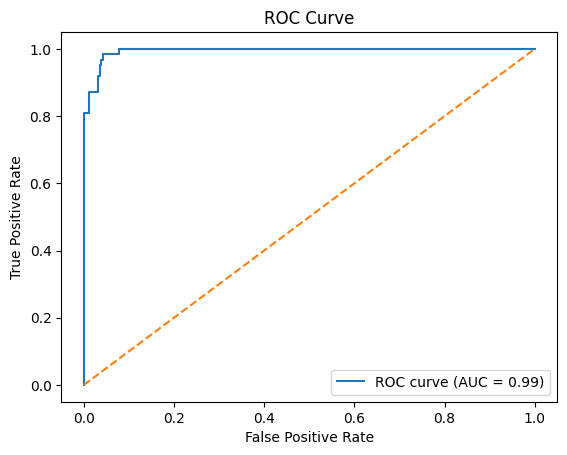

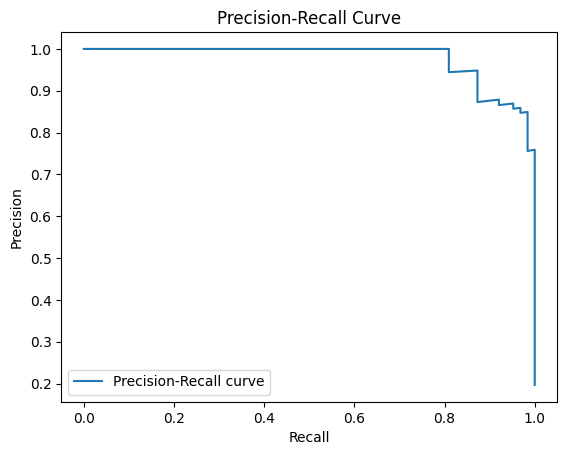

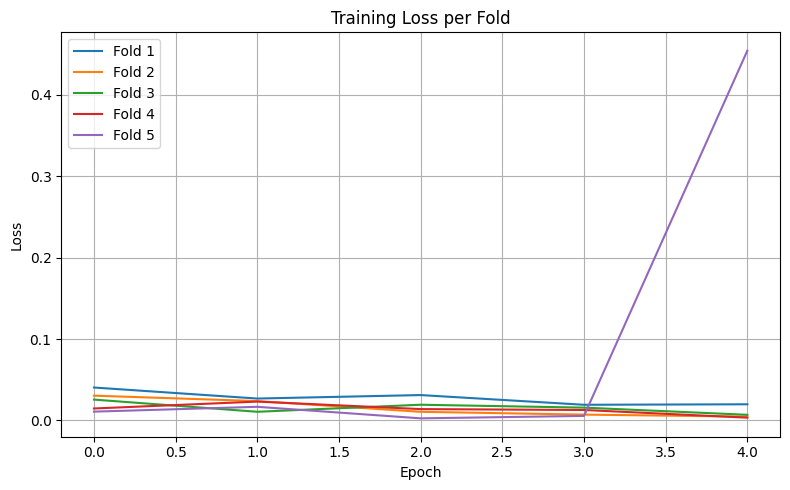

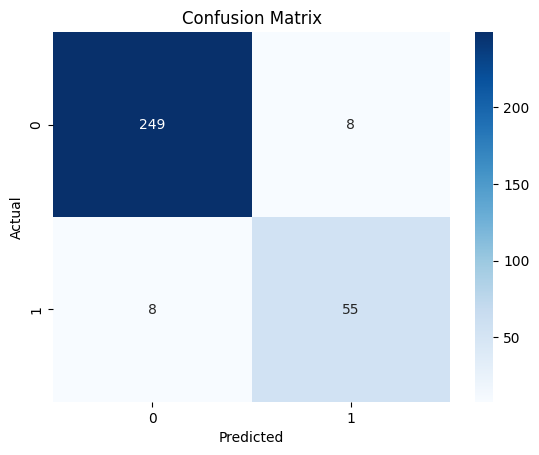


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       257
           1       0.87      0.87      0.87        63

    accuracy                           0.95       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.95      0.95      0.95       320



In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all folds
y_true_all = np.concatenate(all_folds_labels)
y_score_all = np.concatenate(all_folds_scores)
y_pred_all = (y_score_all > 0.5).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_score_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_all, y_score_all)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot training loss per fold
plt.figure(figsize=(8, 5))
for i, loss_history in enumerate(losses):
    plt.plot(loss_history, label=f"Fold {i+1}")
plt.title("Training Loss per Fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_all, y_pred_all))

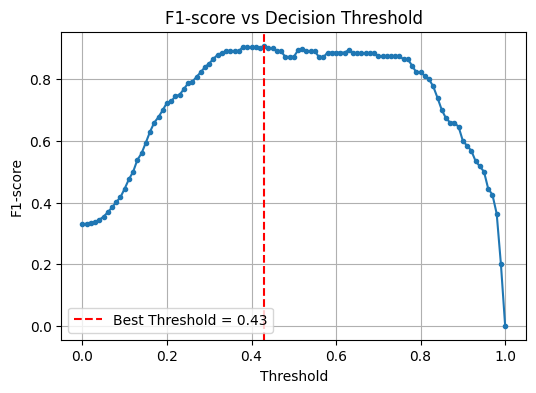

Optimal global F1 threshold = 0.430 (F1 = 0.9091)


In [42]:
def best_f1_threshold(y_true_list, y_score_list, plot=True):
    """
    Find the threshold that maximizes F1-score.

    Parameters:
        y_true  : array-like, true binary labels
        y_score : array-like, predicted probabilities for positive class
        plot    : bool, if True plots F1 vs threshold

    Returns:
        best_thresh (float): threshold that gives best F1
        best_f1 (float): best F1-score value
    """
    y_true = np.concatenate(y_true_list)
    y_score = np.concatenate(y_score_list)
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [f1_score(y_true, y_score >= t) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(thresholds, f1_scores, marker='.')
        plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')
        plt.xlabel("Threshold")
        plt.ylabel("F1-score")
        plt.title("F1-score vs Decision Threshold")
        plt.legend()
        plt.grid(True)
        plt.show()

    return best_thresh, best_f1


(t,f1)= best_f1_threshold(all_folds_labels, all_folds_scores,True)
print(f"Optimal global F1 threshold = {t:.3f} (F1 = {f1:.4f})")


In [43]:
# After evaluating validation data
best_thresh, best_f1 = best_f1_threshold(all_folds_labels, all_folds_scores, plot=False)
print(best_thresh,best_f1)
# Save the threshold for later
with open("model/best_threshold.json", "w") as f:
    json.dump({"threshold": best_thresh}, f)


0.43 0.9090909090909091


In [44]:
(X_test, y_test, lengths_test, group_test) = prepare_data(X_test_, y_test_, sequence_length)
print(X_test.shape)
test_data = ReadmissionDataset(X_test, y_test, lengths_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

(model,y_true,y_score)=evaluate(model, test_loader, device)
print("Test ROC AUC:", roc_auc_score(y_true, y_score))

print("Final shapes:")
print("y_true:", len(y_true))
print("y_score:", len(y_score))
print("Test ROC AUC:", roc_auc_score(y_true, y_score))

(21, 9, 41)
Test ROC AUC: 0.5735294117647058
Final shapes:
y_true: 21
y_score: 21
Test ROC AUC: 0.5735294117647058


In [45]:
# after you've filled all_labels (list of tensors) and all_pos_scores (list of tensors)


# turn probabilities into predicted labels (use a clear threshold, not round)
y_pred = (y_score >= best_thresh).astype(np.int64)

print("Test F1:", f1_score(y_true, y_pred))

Test F1: 0.3333333333333333


Confusion matrix (counts):
 [[17  0]
 [ 3  1]]
Confusion matrix (normalized by true class):
 [[1.   0.  ]
 [0.75 0.25]]

Classification report:
               precision    recall  f1-score   support

           0     0.8500    1.0000    0.9189        17
           1     1.0000    0.2500    0.4000         4

    accuracy                         0.8571        21
   macro avg     0.9250    0.6250    0.6595        21
weighted avg     0.8786    0.8571    0.8201        21



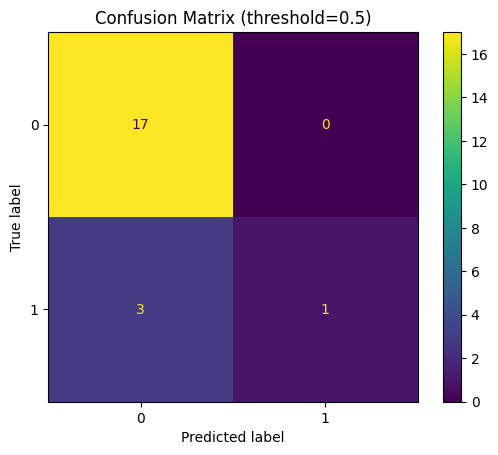

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Pick a threshold (0.5, or your tuned one)
thr = 0.5
y_pred = (y_score >= thr).astype(np.int64)

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion matrix (counts):\n", cm)

# Normalized per true class (i.e., recall per class)
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
print("Confusion matrix (normalized by true class):\n", cm_norm)

# Quick report (precision/recall/F1 per class)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

# Optional: plot (if you’re in a notebook)
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format='d')
plt.title(f'Confusion Matrix (threshold={thr})')
plt.show()

In [47]:
print(best_thresh)
#
#
# flatten lists of tensors -> 1D numpy arrays
from sklearn.metrics import f1_score, classification_report

y_pred = (y_score >=   best_thresh).astype(np.int64)

# optional: nice class names
target_names = ["Negative (0)", "Positive (1)"]

print("Classification report @ threshold =", best_thresh)
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

0.43
Classification report @ threshold = 0.43
              precision    recall  f1-score   support

Negative (0)     0.8421    0.9412    0.8889        17
Positive (1)     0.5000    0.2500    0.3333         4

    accuracy                         0.8095        21
   macro avg     0.6711    0.5956    0.6111        21
weighted avg     0.7769    0.8095    0.7831        21



📊 Classification report @ threshold = 0.430
              precision    recall  f1-score   support

Negative (0)     0.8421    0.9412    0.8889        17
Positive (1)     0.5000    0.2500    0.3333         4

    accuracy                         0.8095        21
   macro avg     0.6711    0.5956    0.6111        21
weighted avg     0.7769    0.8095    0.7831        21


Confusion matrix:
[[16  1]
 [ 3  1]]


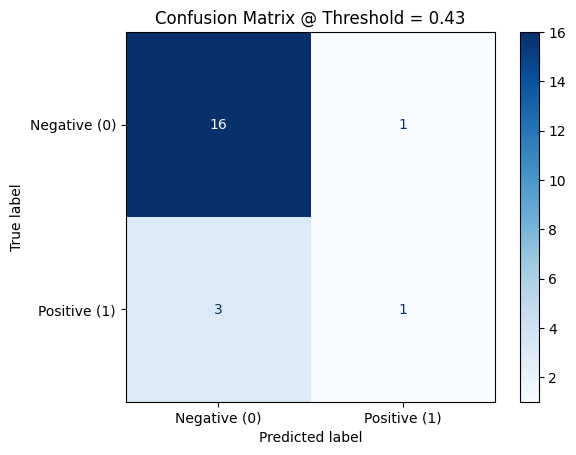

In [48]:
y_pred = (y_score >= best_thresh).astype(np.int64)
target_names = ["Negative (0)", "Positive (1)"]

print(f"📊 Classification report @ threshold = {best_thresh:.3f}")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# 🧮 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)

# Optional: make it pretty
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix @ Threshold = {best_thresh:.2f}")
plt.show()

In [49]:
from sklearn.metrics import precision_recall_curve
prec, rec, thr_list = precision_recall_curve(y_true, y_score)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = 0.5 if best_idx == len(thr_list) else thr_list[best_idx]

y_pred_best = (y_score >= best_thr).astype(np.int64)

print(f"\nClassification report @ best F1 threshold = {best_thr:.3f}")
print(classification_report(y_true, y_pred_best, target_names=target_names, digits=4))


Classification report @ best F1 threshold = 0.046
              precision    recall  f1-score   support

Negative (0)     1.0000    0.2941    0.4545        17
Positive (1)     0.2500    1.0000    0.4000         4

    accuracy                         0.4286        21
   macro avg     0.6250    0.6471    0.4273        21
weighted avg     0.8571    0.4286    0.4442        21



In [50]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
DiagnosisModel                           --
├─LSTMStack: 1-1                         --
│    └─LSTM: 2-1                         65,232
├─CNNExtractor: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  6,200
│    │    └─BatchNorm1d: 3-2             100
│    │    └─ReLU: 3-3                    --
│    │    └─Conv1d: 3-4                  7,550
│    │    └─BatchNorm1d: 3-5             100
│    │    └─ReLU: 3-6                    --
│    │    └─Dropout: 3-7                 --
│    └─AdaptiveAvgPool1d: 2-3            --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       10,176
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       1,040
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       34
Total params: 90,432
Trainable params: 90,432
Non-trainable params: 0